# Loading Model.

In [3]:
import tensorflow.compat.v1 as tf1
tf1.disable_v2_behavior()
from Utils import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Patch size and shift samples.
w1 = 48
w2 = 48
s1z = 1
s2z = 1



# Best Model Name
modw = 'Best_Model_Syn.h5'

# Number of neurons per first and second sub-networks
# Reduce D1 for removing more noise
# Increase D2 for reconstructing more signals.
D1 = 144
D2 = 4225
# Call the MSMHA model
model = MSMHA(D1,D2,w1,w2, modw)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 48, 48)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 2304)         0           input_layer[0][0]                
__________________________________________________________________________________________________
dense (Dense)                   (None, 144)          331920      flatten[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 144)          0           dense[0][0]                      
______________________________________________________________________________________________

# Loading data

<Figure size 640x480 with 0 Axes>

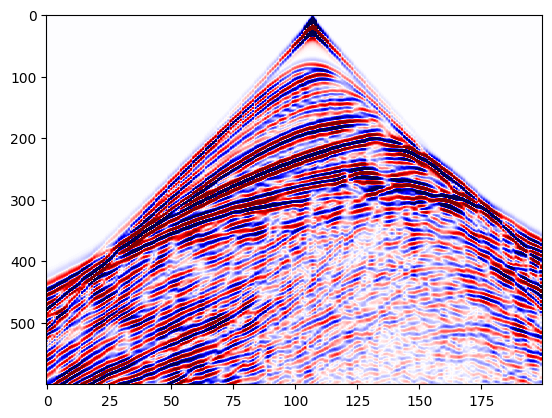

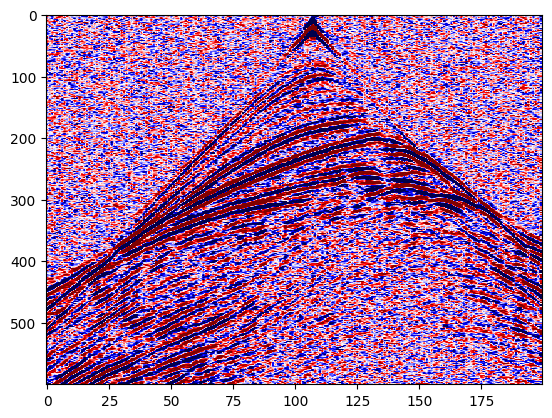

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

clean = np.load('data/clean_Mar_Shot12.npy')
dataNoise = np.load('data/Noisy_Mar_Shot12.npy')


vmin0 = np.quantile(dataNoise, 0.05)
vmax0 = np.quantile(dataNoise, 0.95)

vmin = np.quantile(clean, 0.05)
vmax = np.quantile(clean, 0.95)
plt.figure()
plt.imshow(clean,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.figure()
plt.imshow(dataNoise,aspect='auto',cmap='seismic',vmin = vmin, vmax=vmax)
plt.figure()

# Patching

In [8]:
ma = np.max(np.abs(dataNoise))/100
dataNoise1 = dataNoise/ma
#dataNoise1 = dataNoise
datapatch = yc_patch(dataNoise1,w1,w2,s1z,s2z)   
datapatch1 = np.reshape(datapatch,(datapatch.shape[0],w1,w2))

# Training in an unsupervised manner

In [10]:
import tensorflow
A = 50
def lr_schedule(epoch):
    initial_lr = 1e-4

    if epoch <= A:
        lr = initial_lr
    elif epoch <= A+20:
        lr = initial_lr / 2
    elif epoch <= A+40:
        lr = initial_lr / 10
    else:
        lr = initial_lr / 20
   # print('Learning rate: ', lr)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.5,
                                   cooldown=0,
                                   patience=5,
                                   min_lr=0.5e-6,
                                   monitor='loss')

sgd = tensorflow.keras.optimizers.Adam()
model.compile(optimizer=sgd, loss=['mse','mse'])


early_stopping_monitor = EarlyStopping(monitor= 'loss', patience = 5)

checkpoint = ModelCheckpoint(modw,
                             monitor='loss',
                             mode = 'auto',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True)


callbacks = [lr_scheduler,early_stopping_monitor, checkpoint, lr_reducer]
history = model.fit(datapatch1, [datapatch1,datapatch1], epochs=100, verbose=2, batch_size=128, shuffle=True, callbacks = callbacks)

Train on 84609 samples


2024-03-13 12:45:40.033264: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-13 12:45:40.035491: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-13 12:45:40.080423: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:af:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2024-03-13 12:45:40.080459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-13 12:45:40.252287: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-03-13 12:45:40.252438: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.1

Epoch 1/100


2024-03-13 12:45:56.479900: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10



Epoch 00001: loss improved from inf to 1.51174, saving model to Best_Model_Syn.h5
84609/84609 - 21s - loss: 1.5117 - reshape_1_loss: 0.8209 - reshape_3_loss: 0.6894
Epoch 2/100

Epoch 00002: loss improved from 1.51174 to 1.29736, saving model to Best_Model_Syn.h5
84609/84609 - 18s - loss: 1.2974 - reshape_1_loss: 0.7444 - reshape_3_loss: 0.5519
Epoch 3/100

Epoch 00003: loss improved from 1.29736 to 1.14953, saving model to Best_Model_Syn.h5
84609/84609 - 17s - loss: 1.1495 - reshape_1_loss: 0.6728 - reshape_3_loss: 0.4758
Epoch 4/100

Epoch 00004: loss improved from 1.14953 to 1.04434, saving model to Best_Model_Syn.h5
84609/84609 - 17s - loss: 1.0443 - reshape_1_loss: 0.6200 - reshape_3_loss: 0.4234
Epoch 5/100

Epoch 00005: loss improved from 1.04434 to 0.96562, saving model to Best_Model_Syn.h5
84609/84609 - 17s - loss: 0.9656 - reshape_1_loss: 0.5828 - reshape_3_loss: 0.3828
Epoch 6/100

Epoch 00006: loss improved from 0.96562 to 0.90851, saving model to Best_Model_Syn.h5
84609/8

84609/84609 - 17s - loss: 0.5828 - reshape_1_loss: 0.3668 - reshape_3_loss: 0.2158
Epoch 47/100

Epoch 00047: loss improved from 0.58278 to 0.58142, saving model to Best_Model_Syn.h5
84609/84609 - 17s - loss: 0.5814 - reshape_1_loss: 0.3657 - reshape_3_loss: 0.2158
Epoch 48/100

Epoch 00048: loss improved from 0.58142 to 0.58018, saving model to Best_Model_Syn.h5
84609/84609 - 17s - loss: 0.5802 - reshape_1_loss: 0.3643 - reshape_3_loss: 0.2157
Epoch 49/100

Epoch 00049: loss improved from 0.58018 to 0.57685, saving model to Best_Model_Syn.h5
84609/84609 - 17s - loss: 0.5769 - reshape_1_loss: 0.3629 - reshape_3_loss: 0.2138
Epoch 50/100

Epoch 00050: loss improved from 0.57685 to 0.57493, saving model to Best_Model_Syn.h5
84609/84609 - 17s - loss: 0.5749 - reshape_1_loss: 0.3616 - reshape_3_loss: 0.2130
Epoch 51/100

Epoch 00051: loss improved from 0.57493 to 0.57348, saving model to Best_Model_Syn.h5
84609/84609 - 17s - loss: 0.5735 - reshape_1_loss: 0.3603 - reshape_3_loss: 0.2128
Ep

84609/84609 - 18s - loss: 0.5255 - reshape_1_loss: 0.3404 - reshape_3_loss: 0.1849
Epoch 92/100

Epoch 00092: loss improved from 0.52554 to 0.52465, saving model to Best_Model_Syn.h5
84609/84609 - 18s - loss: 0.5246 - reshape_1_loss: 0.3400 - reshape_3_loss: 0.1844
Epoch 93/100

Epoch 00093: loss improved from 0.52465 to 0.52450, saving model to Best_Model_Syn.h5
84609/84609 - 18s - loss: 0.5245 - reshape_1_loss: 0.3401 - reshape_3_loss: 0.1843
Epoch 94/100

Epoch 00094: loss improved from 0.52450 to 0.52441, saving model to Best_Model_Syn.h5
84609/84609 - 18s - loss: 0.5244 - reshape_1_loss: 0.3399 - reshape_3_loss: 0.1843
Epoch 95/100

Epoch 00095: loss improved from 0.52441 to 0.52430, saving model to Best_Model_Syn.h5
84609/84609 - 17s - loss: 0.5243 - reshape_1_loss: 0.3401 - reshape_3_loss: 0.1842
Epoch 96/100

Epoch 00096: loss improved from 0.52430 to 0.52421, saving model to Best_Model_Syn.h5
84609/84609 - 17s - loss: 0.5242 - reshape_1_loss: 0.3399 - reshape_3_loss: 0.1842
Ep

# Predicting the denoised version

SNR for the noisy data is:6.025352928411065SNR for the denoised version is:16.832189699904504


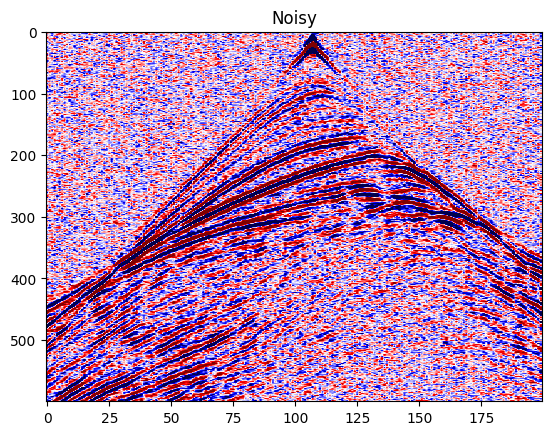

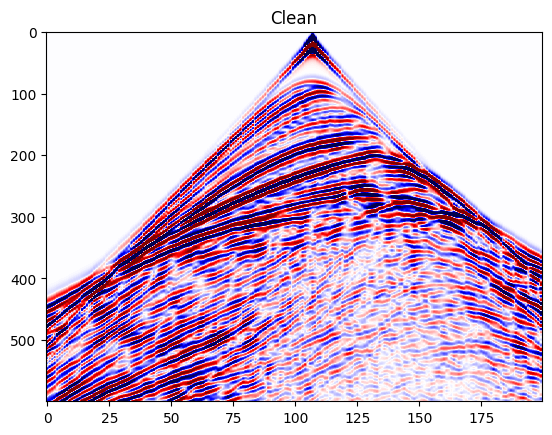

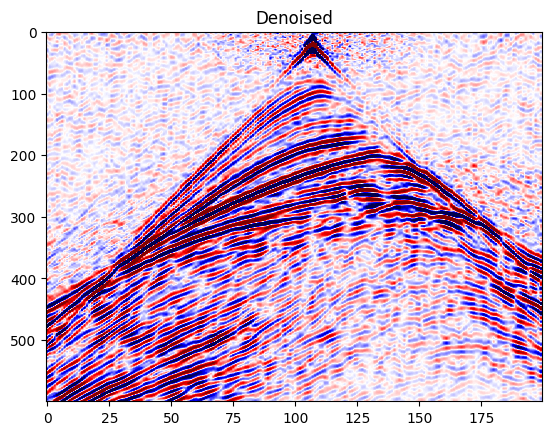

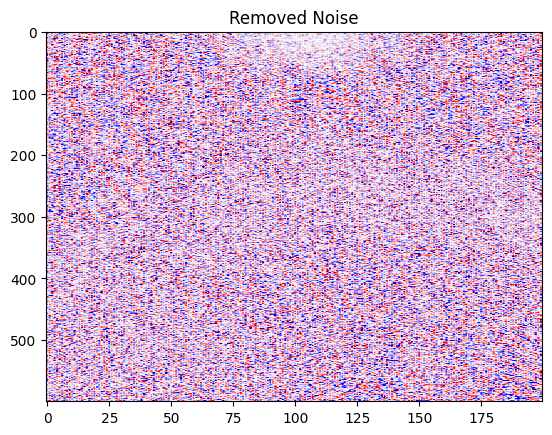

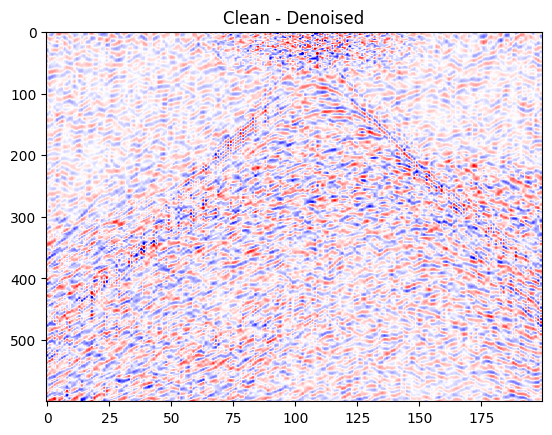

In [19]:
# Load best model
model.load_weights(modw)

# Predict
[ign,out] = model.predict([datapatch1],batch_size=128)
out = out*ma
out = np.reshape(out,(out.shape[0],w1*w2))     

# Unpatching
outA = np.transpose(out)
n1,n2=np.shape(dataNoise)
outB = yc_patch_inv(outA,n1,n2,w1,w2,s1z,s2z)
outB = np.array(outB)

# Plotting
vmin0 = np.quantile(dataNoise, 0.05)
vmax0 = np.quantile(dataNoise, 0.95)


plt.imshow(dataNoise,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.title('Noisy')
plt.figure()
plt.imshow(clean,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.title('Clean')
plt.figure()
plt.imshow(outB,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.title('Denoised')
plt.figure()
plt.imshow(outB-dataNoise,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.title('Removed Noise')
plt.figure()
plt.imshow(outB-clean,aspect='auto',cmap='seismic',vmin = vmin0, vmax=vmax0)
plt.title('Clean - Denoised')

# Save data
np.save('data/denoised_syn',outB)

# SNR before and after MSHMA
print('SNR for the noisy data is:' + str(yc_snr(clean,dataNoise)) + 'SNR for the denoised version is:' + str(yc_snr(clean,outB)))